In [125]:
import numpy as np
from numpy.linalg import inv
import scipy as sci
import control
from scipy.signal import place_poles, StateSpace, lsim
from scipy.linalg import solve_continuous_are
import matplotlib.pyplot as plt
from sim import *
pi = np.pi


In [126]:
## Define SS

RE = 6378 # km
ROrb = 300 # km
r0 = RE + ROrb
mu = 398600


A = np.array([[           0, 1, 0,                0],
                [3*mu/(r0**3), 0, 0, 2*np.sqrt(mu/r0)],
                [ 0, 0, 0, 1],
                [0, -2*np.sqrt(mu/r0**5), 0, 0 ]])

B = np.array([[0,0],
                [1,0],
                [0,0],
                [0,1/r0]])

C = np.array([[1,0,0,0],[0,0,1,0]])

D = np.zeros([2,2])
print(np.linalg.eig(A))



EigResult(eigenvalues=array([0.+0.j        , 0.+0.00115691j, 0.-0.00115691j, 0.+0.j        ]), eigenvectors=array([[ 0.00000000e+000+0.j        ,  9.99999286e-001+0.j        ,
         9.99999286e-001-0.j        ,  1.54248279e-285+0.j        ],
       [ 0.00000000e+000+0.j        ,  0.00000000e+000+0.00115691j,
         0.00000000e+000-0.00115691j,  0.00000000e+000+0.j        ],
       [ 1.00000000e+000+0.j        ,  0.00000000e+000+0.00029949j,
         0.00000000e+000-0.00029949j,  1.00000000e+000+0.j        ],
       [ 0.00000000e+000+0.j        , -3.46483291e-007+0.j        ,
        -3.46483291e-007-0.j        , -4.00833672e-292+0.j        ]]))


In [127]:
## Define Reference Input and Constant Disturbance force

# Period of orbit
T = 2*pi*np.sqrt(r0**3/mu)

# Define simulation time to be 3 orbital periods
tvec = np.linspace(0,2*T,round(20*T))

omega_des = np.sqrt(mu/(r0**3))


# Define reference input

ref = np.vstack((np.zeros(len(tvec)), [0] * len(tvec)))
#ref = np.zeros(len(tvec))

# Define a disturbance profile
d = -1e-4*np.ones([2,len(tvec)])



G = np.array([[0,0],[1,0],[0,0],[0,1/r0]])



In [128]:
## Simulation/Plotting Function

def Simulate_Linear_Controller(sys, U_sim, tvec,K, disturbance = False, feedforward = False, F = None):
    thist, yhist, xhist = lsim(sys, U = U_sim.T, T = tvec)

    # Compute resulting control response
    U = -K@xhist.T

    if feedforward and F is not None:
        ref = U_sim[0:2,:]
        U = -K@xhist.T + F@ref
    elif feedforward:
        print("Error: Must specify F")
        return

    fig, ax = plt.subplots(2,1, figsize=(10, 8), constrained_layout=True)
    ax[0].plot(thist,yhist[:,0],color="#460aec",linewidth=2)
    ax[0].plot(thist, [0] * len(thist),color="#414141",linewidth=2,linestyle='--',label='Reference Input')
    ax[0].set_xlabel("time (s)")
    ax[0].set_ylabel('Radius of Orbit [km]')
    ax[0].set_title('Deviation From Desired Orbital Radius Under Constant Disturbance')
    ax[0].legend()

    ax[1].plot(thist,yhist[:,1],color="#460aec",linewidth=2)
    ax[1].plot(thist, [0] * thist,color="#414141",linewidth=2,linestyle='--',label='Reference Input')
    ax[1].set_xlabel("time (s)")
    ax[1].set_ylabel(r'$\theta$ [rad]')
    ax[1].set_title('Deviation From Desired Orbital Angle Under Constant Disturbance')
    ax[1].legend()

    fig, ax = plt.subplots(2,1, figsize=(10, 8), constrained_layout=True)
    ax[0].plot(thist,U[0,:],color="#ec0a0a",linewidth=2)
    ax[0].plot(thist, [0.5 / 1000] * len(thist),color="#414141",linewidth=2,linestyle='--',label='Maximum Control Input')
    ax[0].plot(thist, [-0.5 / 1000] * len(thist),color="#414141",linewidth=2,linestyle='--')
    ax[0].set_xlabel("time (s)")
    ax[0].set_ylabel(r'$u_1$ [km/$s^2$]')
    ax[0].set_title(r'Control Input u_1')
    ax[0].legend()



    ax[1].plot(thist,U[1,:],color="#ec0a0a",linewidth=2)
    ax[1].plot(thist, [0.5 / 1000] * len(thist),color="#414141",linewidth=2,linestyle='--',label='Maximum Control Input')
    ax[1].plot(thist, [-0.5 / 1000] * len(thist),color="#414141",linewidth=2,linestyle='--')
    ax[1].set_xlabel("time (s)")
    ax[1].set_ylabel(r'$u_2$ [km/$s^2$]')
    ax[1].set_title(r'Control Input u_2')

    if disturbance:

        d = U_sim[2:4,:]

        fig, ax = plt.subplots(2,1, figsize=(10, 8), constrained_layout=True)
        ax[0].plot(thist,d[0,:],color="#000000")
        ax[0].set_xlabel("time (s)")
        ax[0].set_ylabel(r'$\ddot{r_d}$ [km/s^2]')
        ax[0].set_title('Radial acceleration disturbance vs time')

        ax[1].plot(thist,d[1,:],color="#000000")
        ax[1].set_xlabel("time (s)")
        ax[1].set_ylabel(r'$\ddot{\theta}$ [km/s^2]')
        ax[1].set_title('Circumferential acceleration disturbance vs time')

    fig, ax = plt.subplots(4,1, figsize=(10, 8), constrained_layout=True)
    fig.suptitle("Full Perturbed State History")
    ax[0].plot(thist,xhist[:,0],color="#460aec",linewidth=2)
    ax[0].set_ylabel('r [km]')
    ax[1].plot(thist,xhist[:,1],color="#460aec",linewidth=2)
    ax[1].set_ylabel(r'$ \dot{r} $[km/s]')
    ax[2].plot(thist,xhist[:,2],color="#460aec",linewidth=2)
    ax[2].set_ylabel(r'$\theta $[rad]')
    ax[3].plot(thist,xhist[:,3],color="#460aec",linewidth=2)
    ax[3].set_ylabel(r'$\dot{\theta}$ [rad/s]')
    ax[3].set_xlabel("time (s)")

    #ax[4].plot(thist,xhist[:,4])
    #ax[5].plot(thist,xhist[:,5])



System is reachable 

4


C:\Users\bijan\AppData\Local\Temp\ipykernel_33100\3401830393.py:28: UserWarning: Convergence was not reached after maxiter iterations.
You asked for a tolerance of 0.001, we got 0.3104400795845219.
  res = place_poles(AaugOL,BaugOL,des_poles)


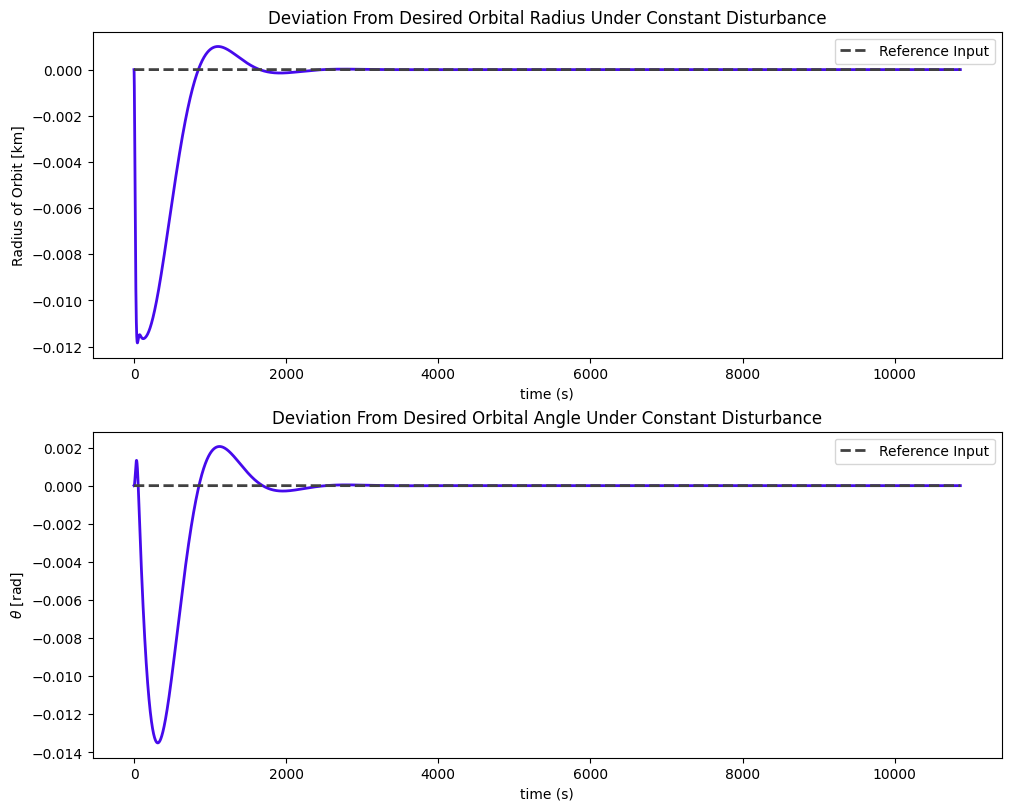

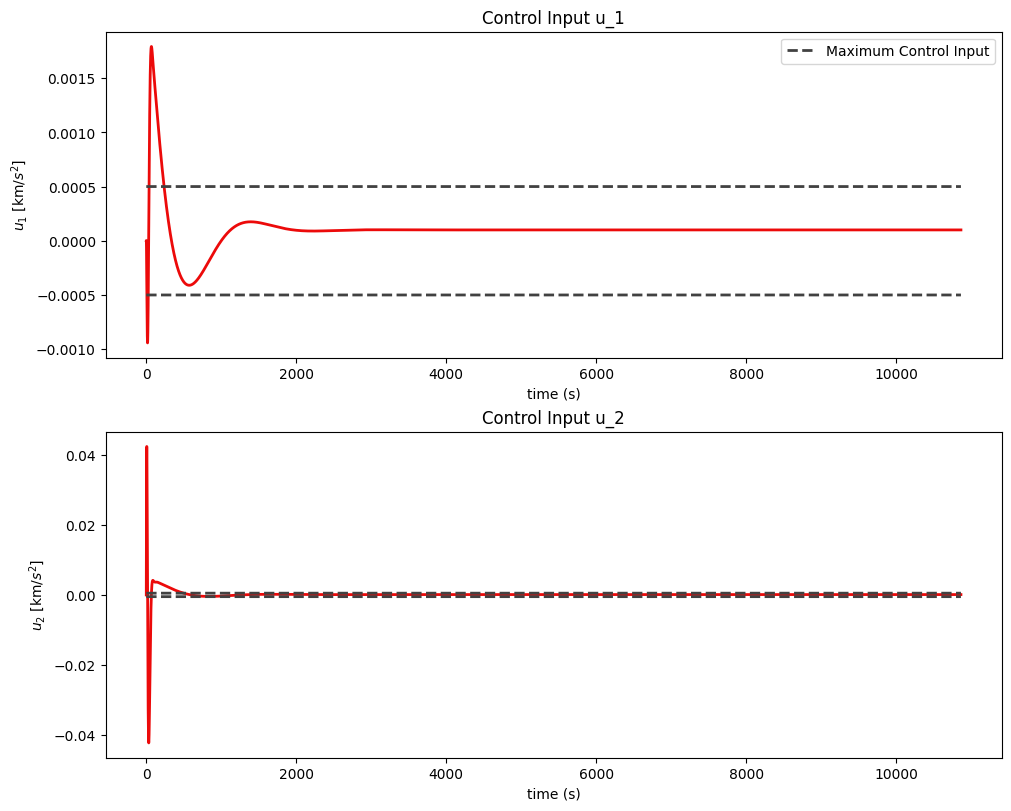

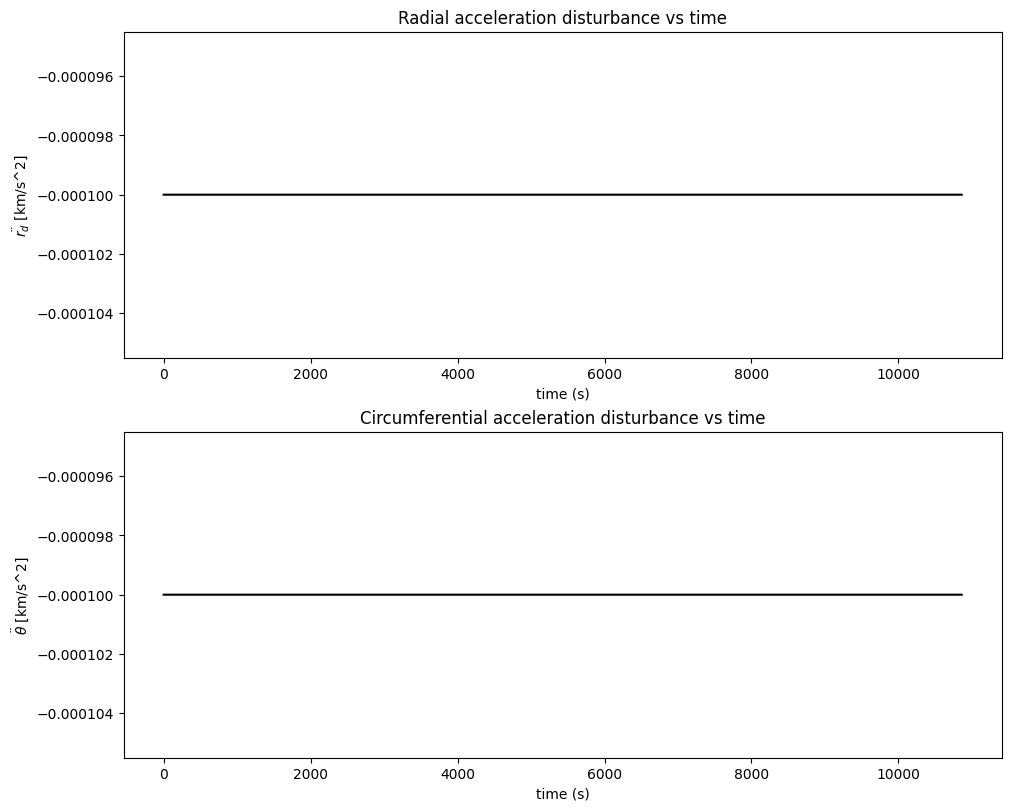

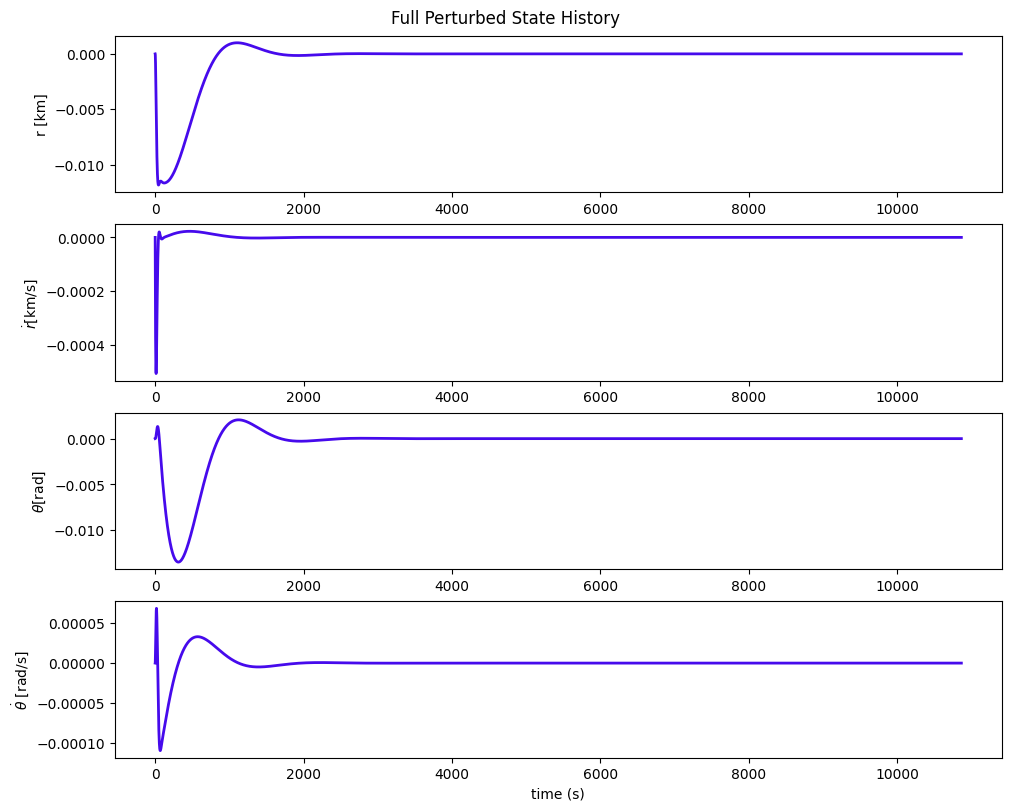

In [129]:
## Integral Controller
# New state: x_aug = [x; x_I]

#Cr = np.array([1,0,0,0]) # C reference, only want to control radius (only reference input)

AaugOL = np.block([[A, np.zeros([4,2])],[-C, np.zeros([2,2])]])
BaugOL = np.block([[B],[np.zeros([2,2])]])
CaugOL = np.block([C, np.zeros([2,2])])
DaugOL = np.zeros([2,4])
# Check reachability of system
P = control.ctrb(AaugOL,BaugOL)
O = control.obsv(AaugOL,CaugOL)

r = np.linalg.matrix_rank(P)
n_states = AaugOL.shape[0]

if n_states == r:
    print("System is reachable \n")

r = np.linalg.matrix_rank(O)
print(r)
if n_states == r:
    print("System is observable \n")



des_poles = np.array([-0.06447573+0.07792534j, -0.06447573-0.07792534j, -0.06182676, -0.00476327,-0.00236805+0.00377825j, -0.00236805-0.00377825j])
res = place_poles(AaugOL,BaugOL,des_poles)
Ka = res.gain_matrix
AaugCL = AaugOL - BaugOL@Ka
BaugCL = np.block([[np.zeros([4,2]),G],[np.array([[1,0],[0,1]]),np.zeros([2,2])]])

sys = StateSpace(AaugCL,BaugCL,CaugOL,DaugOL)

ctr = np.block([[ref],[d]])

Simulate_Linear_Controller(sys, ctr, tvec,Ka, disturbance = True)




Text(0.5, 1.0, 'Deviation From Reference Orbit in RIC Coordinates')

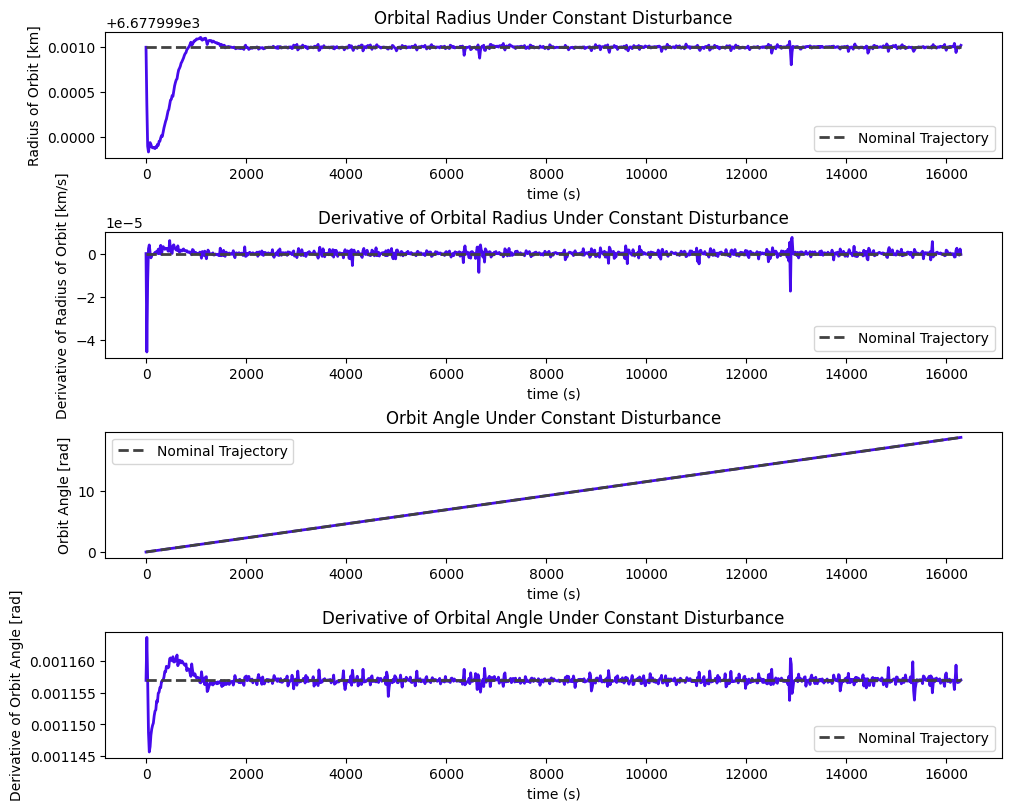

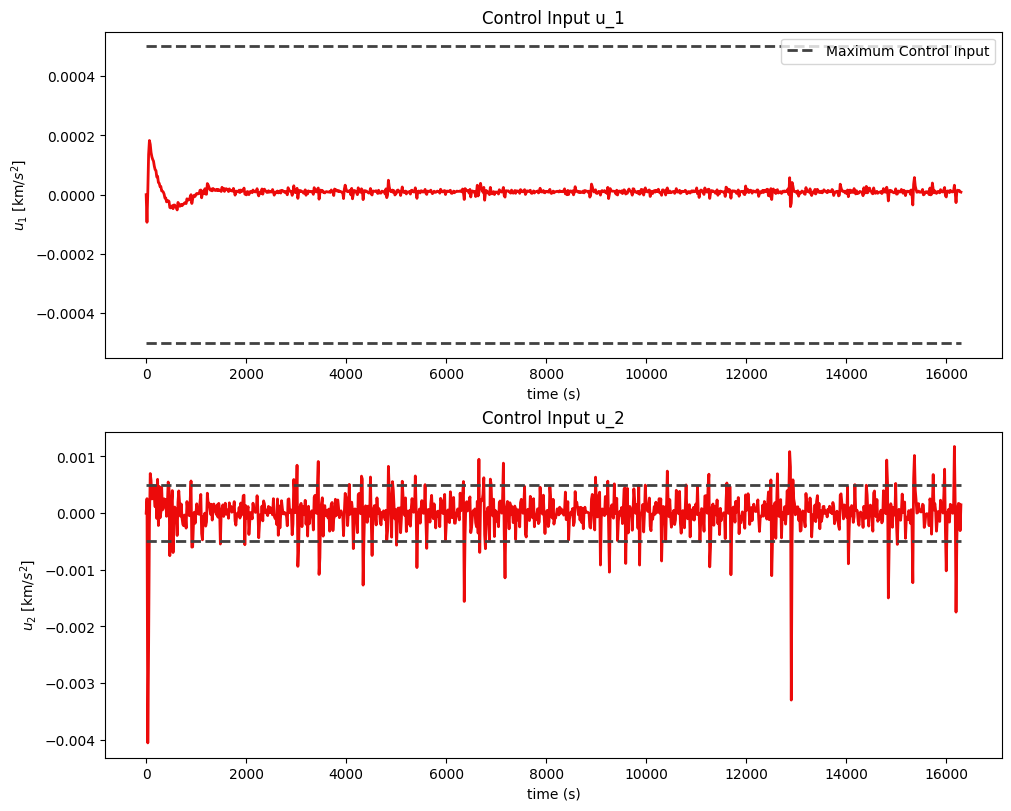

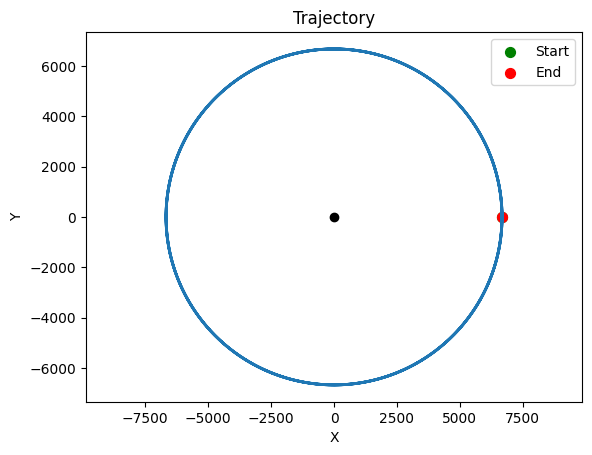

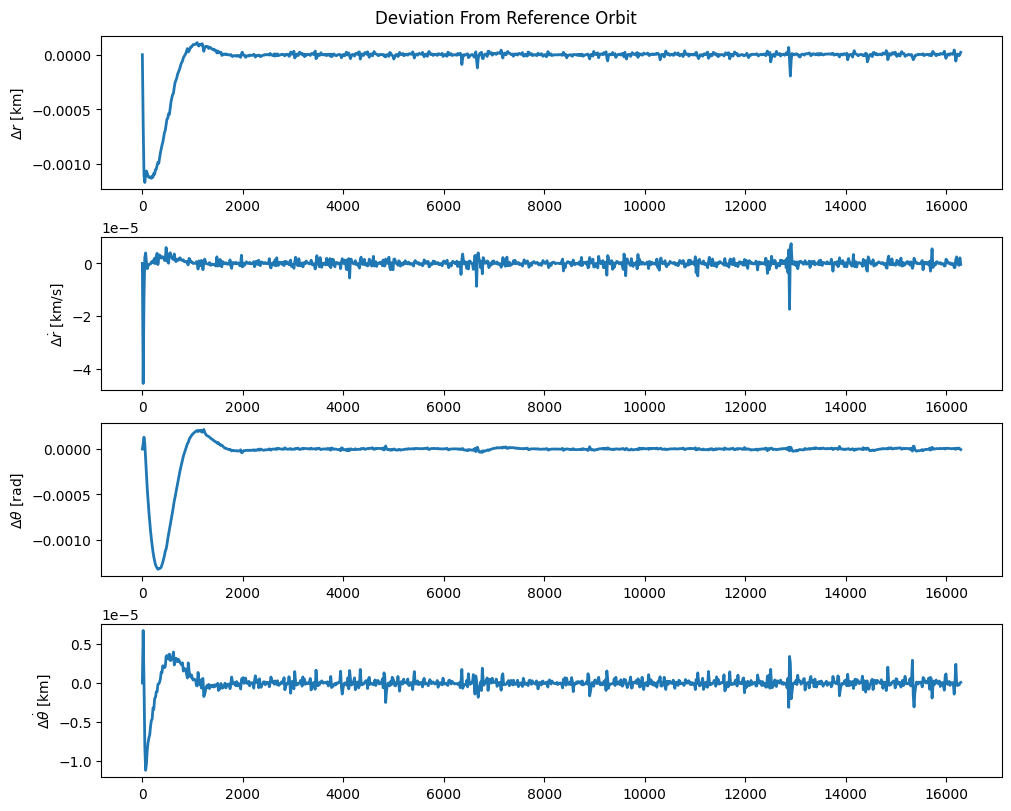

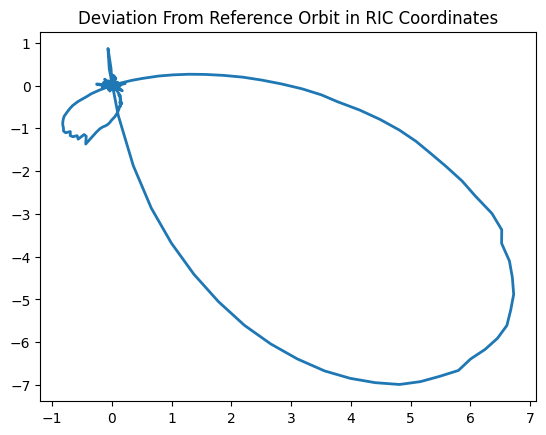

In [150]:
## Use control law with NL dynamics

def contr_func(X, K):
    return -K@X

def sim_func(t,X, U, mu, R = None,dist = 0):
    r = X[0]
    r_dot = X[1]
    theta = X[2]
    theta_dot = X[3]
    

    X_dot = np.zeros(6)

    X_nom = np.array([r0,0,omega_des*t,omega_des,0,0]).T
    
    e = X-X_nom
    Ulin = U(e, R)

    u1 = Ulin[0]
    u2 = Ulin[1]


    X_dot[0] = r_dot
    X_dot[1] = r*theta_dot**2 - mu/(r**2) + u1 + dist
    X_dot[2] = theta_dot
    X_dot[3] = -2*theta_dot*r_dot/r + u2/r + dist/r
    X_dot[4] = -e[0]
    X_dot[5] = -e[2]


    return X_dot

def prop_orbit_controller(X0, tspan, Ufxn,mu, K, num_eval = 1000):
    int_func = lambda t, X: sim_func(t,X, Ufxn,  mu, K,dist=-0.1e-4)
    teval = np.linspace(tspan[0], tspan[1], num_eval)
    sol = sci.integrate.solve_ivp(int_func, tspan, X0, t_eval= teval)

    return [sol.y, sol.t]
X_diff = np.array([0,0,0,0,0,0])
X_ideal = np.array([r0,0,0,omega_des,0,0])
X0 = X_ideal + X_diff
tspan = [0, 3*T]

X, t = prop_orbit_controller(X0 = X0, tspan = tspan,Ufxn = contr_func,mu =mu,K = Ka)


fig, ax = plt.subplots(4,1, figsize=(10, 8), constrained_layout=True)
ax[0].plot(t,X[0,:],color="#460aec",linewidth=2)
ax[0].plot(t, [r0] * len(t),color="#414141",linewidth=2,linestyle='--',label='Nominal Trajectory')
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel('Radius of Orbit [km]')
ax[0].set_title('Orbital Radius Under Constant Disturbance')
ax[0].legend()

ax[1].plot(t,X[1,:],color="#460aec",linewidth=2)
ax[1].plot(t, [0] * len(t),color="#414141",linewidth=2,linestyle='--',label='Nominal Trajectory')
ax[1].set_xlabel("time (s)")
ax[1].set_ylabel('Derivative of Radius of Orbit [km/s]')
ax[1].set_title('Derivative of Orbital Radius Under Constant Disturbance')
ax[1].legend()

ax[2].plot(t,X[2,:],color="#460aec",linewidth=2)
ax[2].plot(t, [omega_des] * t,color="#414141",linewidth=2,linestyle='--',label='Nominal Trajectory')
ax[2].set_xlabel("time (s)")
ax[2].set_ylabel('Orbit Angle [rad]')
ax[2].set_title('Orbit Angle Under Constant Disturbance')
ax[2].legend()

ax[3].plot(t,X[3,:],color="#460aec",linewidth=2)
ax[3].plot(t, [omega_des] * len(t),color="#414141",linewidth=2,linestyle='--',label='Nominal Trajectory')
ax[3].set_xlabel("time (s)")
ax[3].set_ylabel('Derivative of Orbit Angle [rad]')
ax[3].set_title('Derivative of Orbital Angle Under Constant Disturbance')
ax[3].legend()

U = np.zeros([2,len(t)])


for i in range(len(t)):
    X_nom = np.array([r0,0,omega_des*t[i],omega_des,0,0]).T
    temp =  contr_func(X[:,i]-X_nom,Ka)
    np.reshape(temp,[1,2])
    U[0,i] = temp[0]
    U[1,i] = temp[1]



fig, ax = plt.subplots(2,1, figsize=(10, 8), constrained_layout=True)
ax[0].plot(t,U[0,:],color="#ec0a0a",linewidth=2)
ax[0].plot(t, [0.5 / 1000] * len(t),color="#414141",linewidth=2,linestyle='--',label='Maximum Control Input')
ax[0].plot(t, [-0.5 / 1000] * len(t),color="#414141",linewidth=2,linestyle='--')
ax[0].set_xlabel("time (s)")
ax[0].set_ylabel(r'$u_1$ [km/$s^2$]')
ax[0].set_title(r'Control Input u_1')
ax[0].legend(loc='upper right')



ax[1].plot(t,U[1,:],color="#ec0a0a",linewidth=2)
ax[1].plot(t, [0.5 / 1000] * len(t),color="#414141",linewidth=2,linestyle='--',label='Maximum Control Input')
ax[1].plot(t, [-0.5 / 1000] * len(t),color="#414141",linewidth=2,linestyle='--')
ax[1].set_xlabel("time (s)")
ax[1].set_ylabel(r'$u_2$ [km/$s^2$]')
ax[1].set_title(r'Control Input u_2')

plot_XY(X)

X_ref = np.array([r0*np.ones(len(t)),np.zeros(len(t)),omega_des*t,omega_des*np.ones(len(t)),[0] * len(t), [0] * len(t)])

Xref_cart = polar_to_cart_inertial(X_ref)
X_cart = polar_to_cart_inertial(X)

t_diff, X_diff = orbit_diff(X_ref, t, X, t)
t_diff_cart, X_diff_cart = orbit_diff(Xref_cart, t, X_cart, t)

fig,ax = plt.subplots(4,1, figsize=(10, 8), constrained_layout=True)
fig.suptitle("Deviation From Reference Orbit")
ax[0].plot(t, X_diff[0],linewidth=2)
ax[0].set_ylabel(r'$\Delta r$ [km]')
ax[1].plot(t, X_diff[1],linewidth=2)
ax[1].set_ylabel(r'$\Delta\dot{r}$ [km/s]')
ax[2].plot(t, X_diff[2],linewidth=2)
ax[2].set_ylabel(r'$\Delta\theta$ [rad]')
ax[3].plot(t, X_diff[3],linewidth=2)
ax[3].set_ylabel(r'$\Delta\dot{\theta}$ [km]')

Xdiff_ric = np.zeros(X_diff_cart.shape)
for i in range(Xdiff_ric.shape[1]):
    rot_mat = RI_rot_from_XY(Xref_cart[:,i])
    diff_ric = rot_mat @ X_diff_cart[:,i]
    Xdiff_ric[:,i] = diff_ric

fig,ax = plt.subplots()
ax.plot(Xdiff_ric[0], Xdiff_ric[1],linewidth=2)
ax.set_title("Deviation From Reference Orbit in RIC Coordinates")


In [131]:
## Solve ricatti equation for LQR demo

def solve_ARE(A,B,Q,R):
    """
        Returns K matrix, solution to algebraic ricatti equation P, and CL evals
    """

    # Solve ARE
    P = solve_continuous_are(A,B,Q,R)

    # Compute LQR gain
    K = np.linalg.inv(R) @ B.T @ P
    
    # Closed loop evals
    evals = np.linalg.eigvals(A - B @ K)

    return K, P, evals


[-0.06447573+0.07792534j -0.06447573-0.07792534j -0.06182676+0.j
 -0.00476327+0.j         -0.00236805+0.00377825j -0.00236805-0.00377825j]


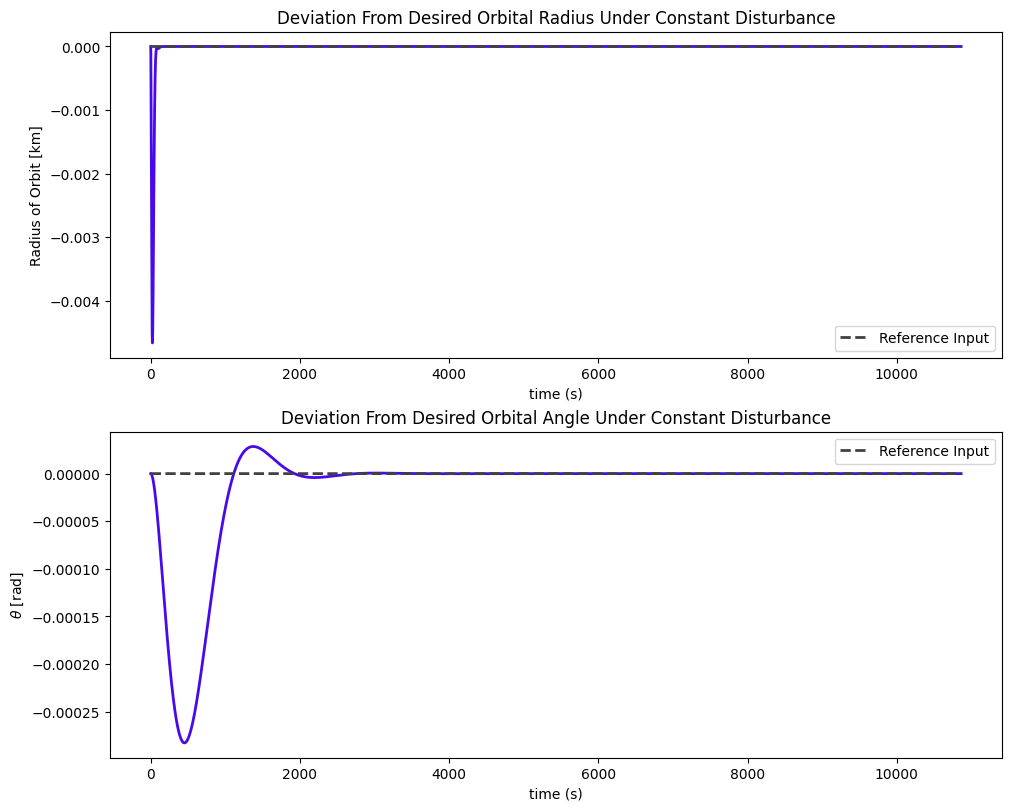

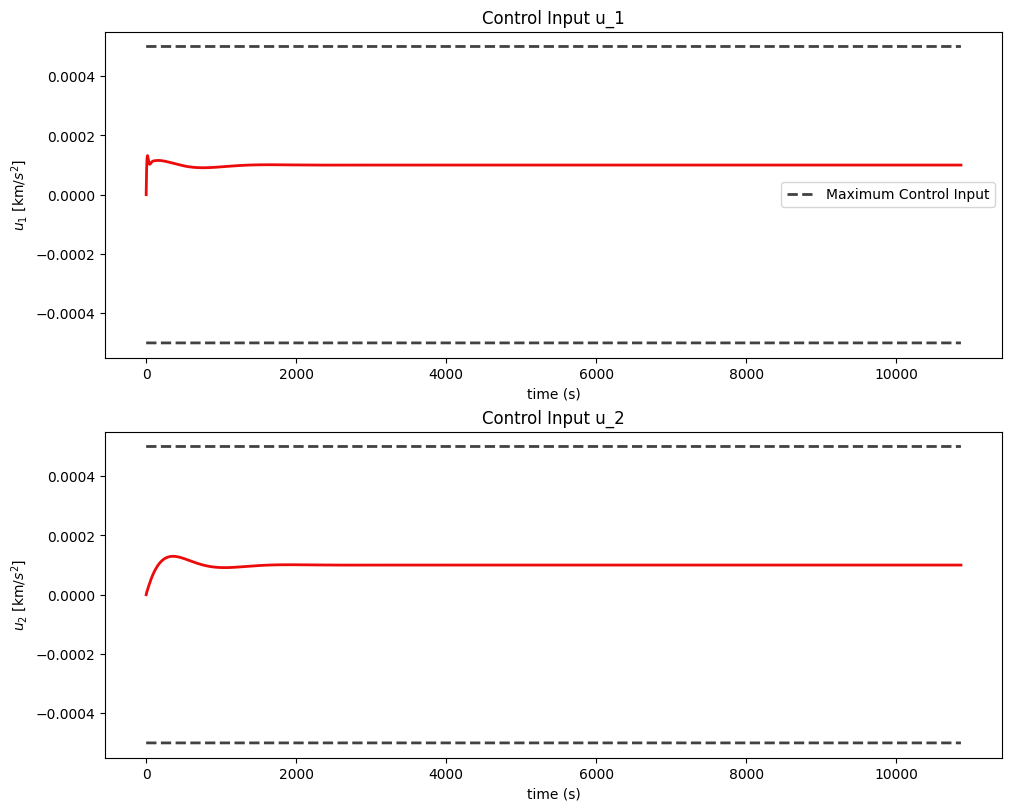

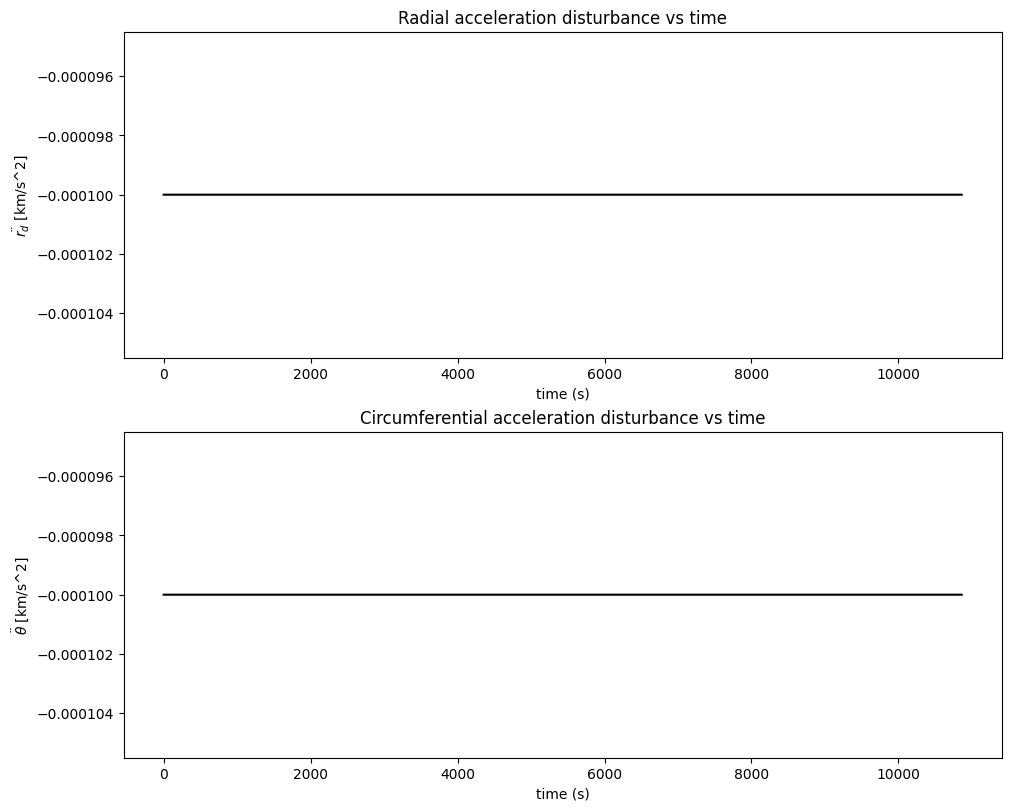

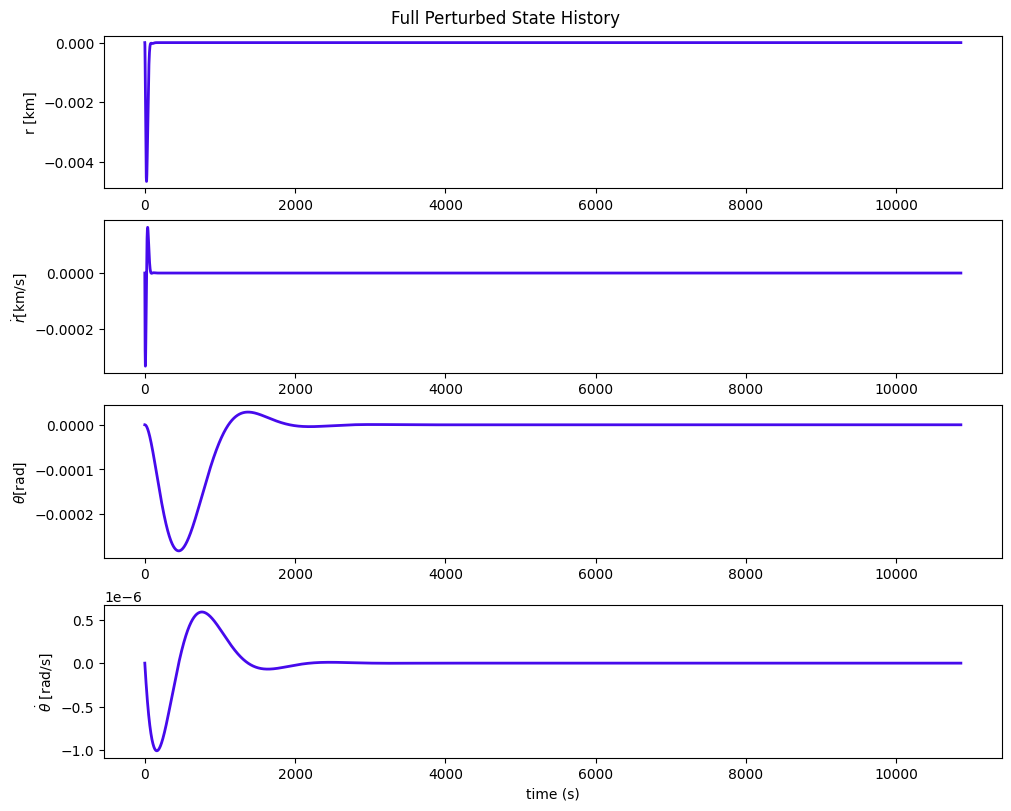

In [132]:
## LQR demo with "perfect" state feedback

# Tuning knobs
max_r = 0.01
max_rdot = 0.1
max_theta = 0.01
max_thetadot = 0.1
max_integral = 0.1

# Don't care as much as about controlling rdot and theta dot
r_wt = 0.3
rdot_wt = 0.1
theta_wt = 0.3
thetadot_wt = 0.1
integral_wt = 0.2


max_u = 0.0005
ctr_wt = 0.5

Q = np.diag([r_wt**2/max_r**2,rdot_wt**2/max_rdot**2,theta_wt**2/max_theta**2,thetadot_wt**2/max_thetadot**2,integral_wt**2/max_integral**2,integral_wt**2/max_integral**2])
R = 10*np.diag([ctr_wt**2/max_u**2,ctr_wt**2/max_u**2])

K, P, evals = solve_ARE(AaugOL,BaugOL,Q,R)
print(evals)
AaugCL = AaugOL - BaugOL@K
BaugCL = np.block([[np.zeros([4,2]),G],[np.array([[1,0],[0,1]]),np.zeros([2,2])]])

sys = StateSpace(AaugCL,BaugCL,CaugOL,DaugOL)

ctr = np.block([[ref],[d]])

Simulate_Linear_Controller(sys, ctr, tvec,K, disturbance = True)




K = [[ 2.41766979e-01  9.85271430e-01 -6.64042789e-02  1.53238500e+01]
 [-4.43447829e+02 -8.53587401e+02  5.02432925e+02  4.43905739e+03]], 
 F = [[ 2.41762964e-01 -6.64042789e-02]
 [-4.43447829e+02  5.02432925e+02]]


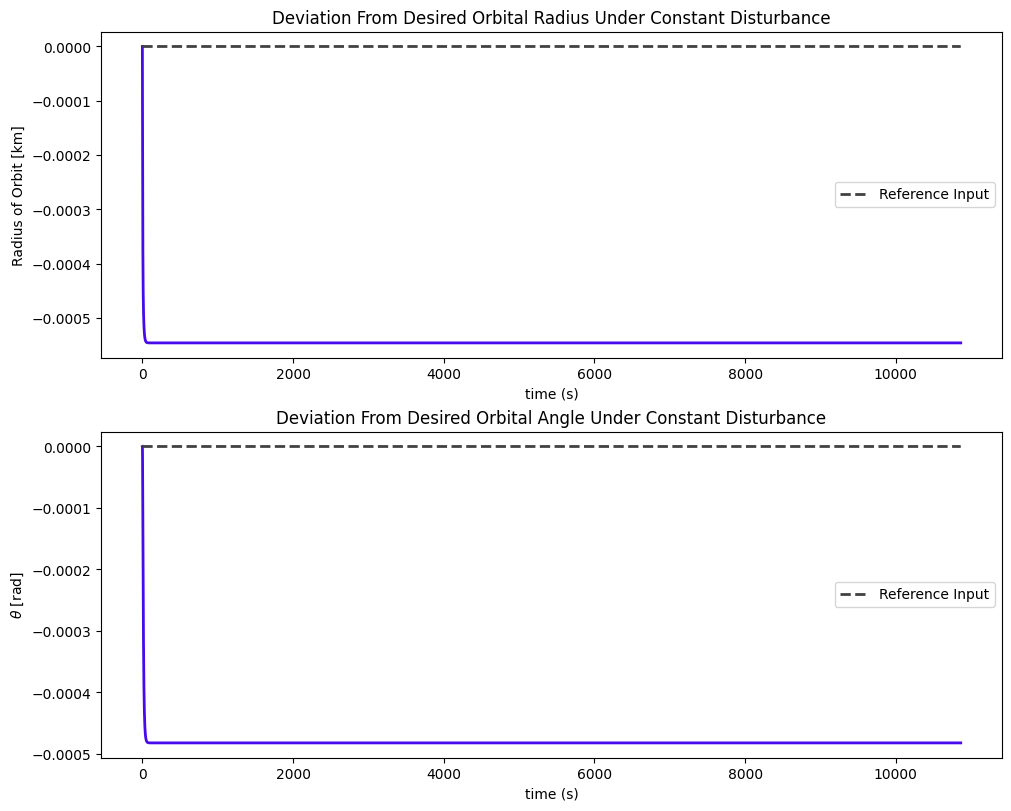

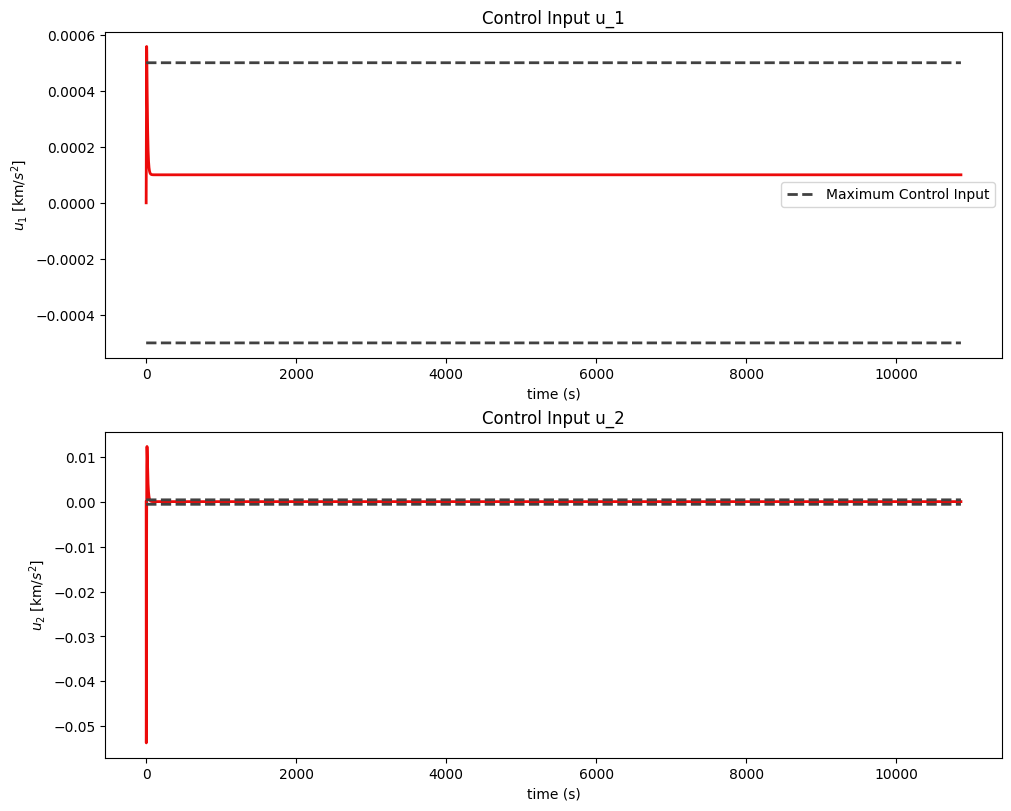

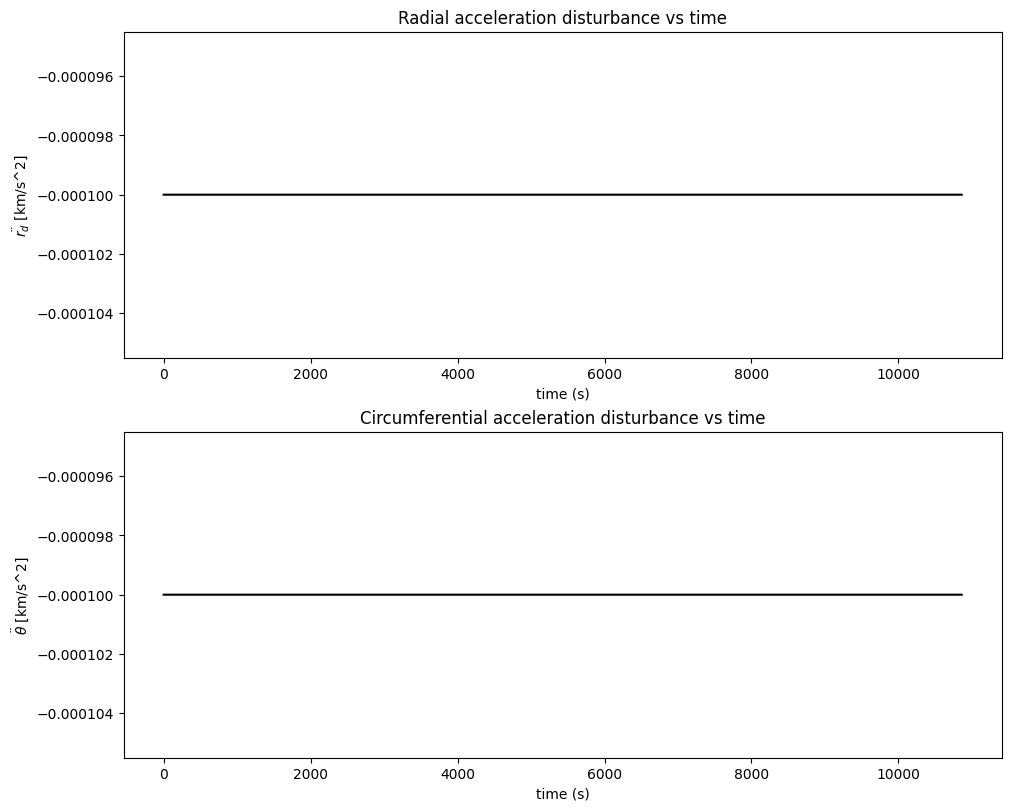

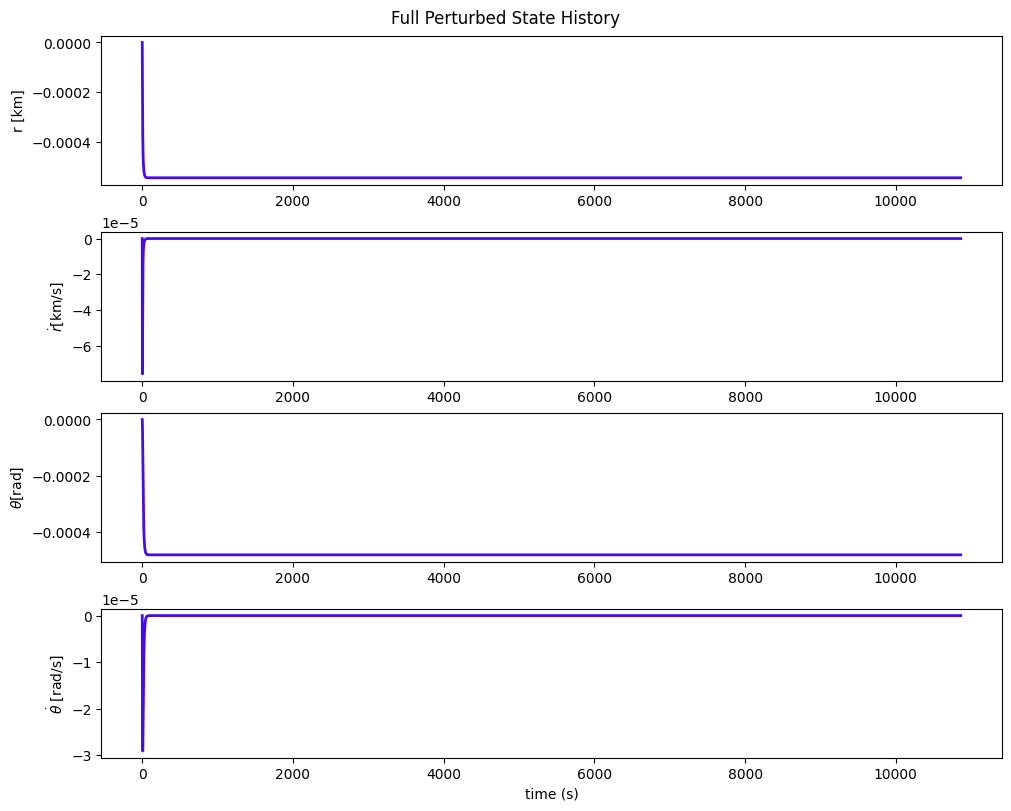

In [133]:
## Test: Use only feedforward tracking

des_poles = np.array([-0.1, -0.5,-0.52,-0.53])

res = place_poles(A,B,des_poles)
K = res.gain_matrix

# Feedforward gain
F = inv(C @ inv(-A + B@K) @ B)

print(f"K = {K}, \n F = {F}")
## Define closed loop system

Acl = A - B@K
Bcl = np.block([B@F, G])
Ccl = C
Dcl = np.zeros([C.shape[0],Bcl.shape[1]])

sys = StateSpace(Acl,Bcl,Ccl,Dcl)

ctr = np.block([[ref],[d]])

Simulate_Linear_Controller(sys, ctr, tvec,K, disturbance = True, feedforward  = True, F = F)

